In [34]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast
import DSA
import copy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load config

In [35]:
config = load_config("../config.yaml")
taskset = "PDM"

In [36]:
def parse_model_info(model_name):
    model_name = model_name.replace('.pth', '')
    model_name = model_name.split('_')
    model_type = model_name[0] + '_' + model_name[1]
    if len(model_name) == 8:    
        activation = model_name[2] + '_' + model_name[3]
        hidden_size = int(model_name[4])
        learning_rate = float(model_name[5])
        batch_size = int(model_name[6])
    else:
        activation = model_name[2]
        hidden_size = int(model_name[3])
        learning_rate = float(model_name[4])
        batch_size = int(model_name[5])
    return model_type, activation, hidden_size, learning_rate, batch_size

parse_model_info('leaky_gru_softplus_128_0.001_128_train.pth')



('leaky_gru', 'softplus', 128, 0.001, 128)

In [37]:
def get_dynamics_rnn(rnn_type, activation, hidden_size, lr, model, group,device, n_components=3):
    # Load configuration and set hyperparameters
    config = load_config("../config.yaml")
    ruleset = config[taskset]["rules_analysis"][-1]
    all_rules = config[taskset]["rules_analysis"]

    hp = {
        "rnn_type": rnn_type,
        "activation": activation,
        "n_rnn": hidden_size,
        "learning_rate": lr,
        "l2_h": 0.00001,
        "l2_weight": 0.00001,
        "mode": "test",
    }
    hp, _, _ = main.set_hyperparameters(
        model_dir="debug", hp=hp, ruleset=all_rules, rule_trains=ruleset
    )
    run_model = main.load_model(
        f"../models/{taskset}/{group}/{model}",
        hp,
        RNNLayer,
        device=device,
    )
    h = main.representation(run_model, all_rules)
    return h

### Get dynamics to plot

In [38]:
model = "leaky_gru_softplus_128_0.001_128_train.pth"

#### Pretrain unfrozen

In [39]:
group = "master"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve_master = get_dynamics_rnn(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=20
)

In [40]:
group = "pretrain_unfrozen"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve_pretrain_unfrozen = get_dynamics_rnn(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=20
)

In [41]:
group = "pretrain_frozen"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve_pretrain_frozen= get_dynamics_rnn(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=20
)

In [42]:
group = "untrained"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve_untrained = get_dynamics_rnn(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=20
)

In [43]:
group = "pretrained_basic_anti_frozen"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve_pretrained_basic_anti_frozen = get_dynamics_rnn(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=20
)

In [44]:
curves = [curve_untrained, curve_master, curve_pretrained_basic_anti_frozen, curve_pretrain_frozen, curve_pretrain_unfrozen]
# normalize all the curves
# for i in range(len(curves)):
#     curves[i] = (curves[i] - np.mean(curves[i])) / np.std(curves[i])

In [45]:
# reduce again curves to 3 components only to visualize
curves_reduced_to_plot, explained_variance = main.compute_common_pca(curves, n_components=3)

In [46]:
explained_variance

0.47777744167961944

#### Visualize the curves

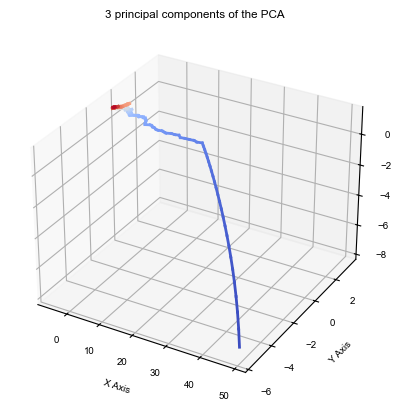

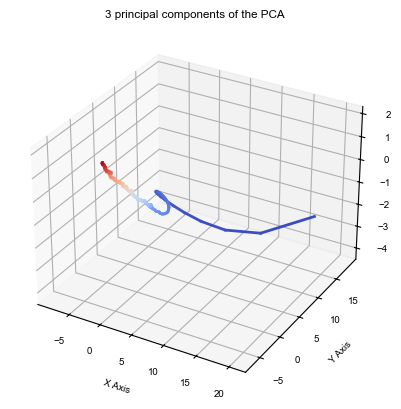

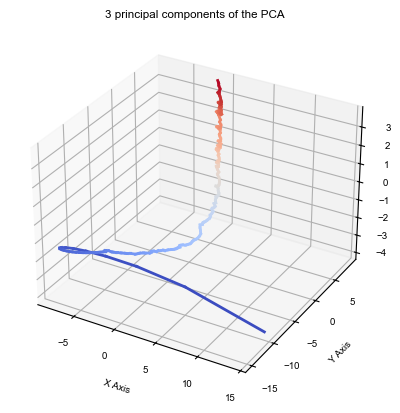

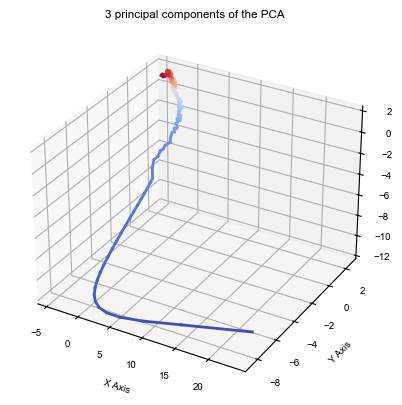

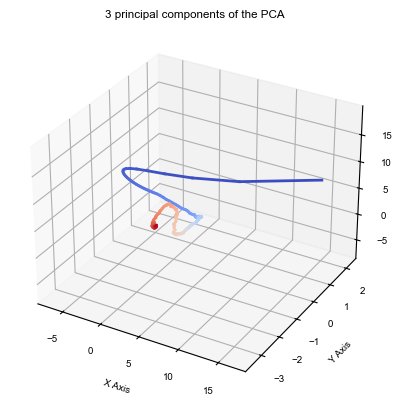

In [47]:
# visualize(curves_reduced_to_plot,title="master, pretrain_frozen, pretrain_unfrozen,pretrained_basic_anti_unfrozen, untrained")
visualize(
    [
        curves_reduced_to_plot[0][:, 100, :],
        curves_reduced_to_plot[1][:, 100, :],
        curves_reduced_to_plot[2][:, 100, :],
        curves_reduced_to_plot[3][:, 100, :],
        curves_reduced_to_plot[4][:, 100, :],
    ],
    title="3 principal components of the PCA",
)

In [48]:
dissimilarities = np.zeros((len(curves), len(curves)))
for i in range(len(curves)):
    for j in range(i, len(curves)):
        # compute DSA dissimilarity matrix
        # compute common pca between two curves
        curves_reduced, explained_variance = main.compute_common_pca([curves[i], curves[j]], n_components=20)
        print(f"Explained variance between {i} and {j}: {explained_variance}")
        dsa_comp = DSA.DSA(
                        curves_reduced[0],
                        curves_reduced[1],
                        # n_delays=config["dsa"]["n_delays"],
                        n_delays=33,
                        rank=100,
                        # delay_interval=config["dsa"]["delay_interval"],
                        delay_interval=6,
                        verbose=True,
                        iters=1000,
                        lr=1e-2,
                        device="cpu",
                    )
        dis = dsa_comp.fit_score()
        dissimilarities[i, j] = dis

Explained variance between 0 and 0: 0.9999358824003763
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Explained variance between 0 and 1: 0.9975340960588804
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Explained variance between

In [49]:
for i in range(len(curves)):
    for j in range(i):
        dissimilarities[i, j] = dissimilarities[j, i]

In [50]:
print(curves[0].shape)

torch.Size([200, 200, 128])


<Axes: >

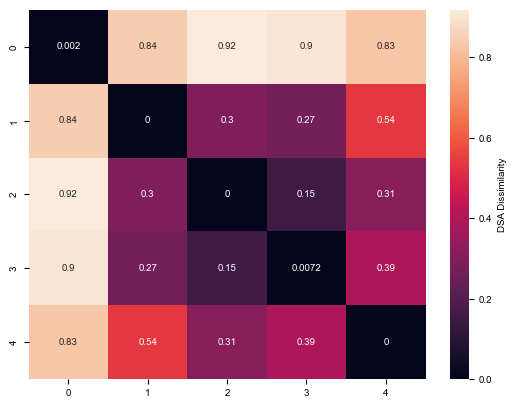

In [51]:
# plot DSA dissimilarity matrix with heatmap and annotations as strings of curves
sns.heatmap(dissimilarities, annot=True, cbar_kws={"label": "DSA Dissimilarity"})